In [67]:
import Pkg
Pkg.add("Ipopt")
Pkg.add("JuMP")
Pkg.add(url = "https://github.com/algorithmsbooks/DecisionMakingProblems.jl")
Pkg.add("Distributions")
Pkg.add("LinearAlgebra")
Pkg.add("JLD")
Pkg.add("Plots")

import Base.Iterators: product
using JuMP, Ipopt, Distributions, LinearAlgebra, JLD, Plots
using DecisionMakingProblems

   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`


    Updating git-repo `https://github.com/algorithmsbooks/DecisionMakingProblems.jl`


   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\tubmt\.julia\environments\v1.6\Manifest.toml`

In [68]:
struct SetCategorical{S}
    elements::Vector{S} # Set elements (could be repeated)
    distr::Categorical # Categorical distribution over set elements
    
    function SetCategorical(elements::AbstractVector{S}) where S
        weights = ones(length(elements))
        return new{S}(elements, Categorical(normalize(weights, 1)))
    end

    function SetCategorical(elements::AbstractVector{S}, weights::AbstractVector{Float64}) where S
        ℓ₁ = norm(weights,1)
        if ℓ₁ < 1e-6 || isinf(ℓ₁)
            return SetCategorical(elements)
        end
        distr = Categorical(normalize(weights, 1))
        return new{S}(elements, distr)
    end
end

Distributions.rand(D::SetCategorical) = D.elements[rand(D.distr)]
Distributions.rand(D::SetCategorical, n::Int) = D.elements[rand(D.distr, n)]

    function Distributions.pdf(D::SetCategorical, x)
    sum(e == x ? w : 0.0 for (e,w) in zip(D.elements, D.distr.p))
end

In [69]:
struct SimpleGamePolicy
    p # dictionary mapping actions to probabilities

    function SimpleGamePolicy(p::Base.Generator)
        return SimpleGamePolicy(Dict(p))
    end

    function SimpleGamePolicy(p::Dict)
        vs = collect(values(p))
        vs ./= sum(vs)
        return new(Dict(k => v for (k,v) in zip(keys(p), vs)))
    end
    
    SimpleGamePolicy(ai) = new(Dict(ai => 1.0))
end

(πi::SimpleGamePolicy)(ai) = get(πi.p, ai, 0.0)

function (πi::SimpleGamePolicy)()
    D = SetCategorical(collect(keys(πi.p)), collect(values(πi.p)))
    return rand(D)
end

joint(X) = vec(collect(product(X...)))
joint(π, πi, i) = [i == j ? πi : πj for (j, πj) in enumerate(π)]

function utility(𝒫::SimpleGame, π, i)
    𝒜, R = 𝒫.𝒜, 𝒫.R
    p(a) = prod(πj(aj) for (πj, aj) in zip(π, a))
    return sum(R(a)[i]*p(a) for a in joint(𝒜))
end

utility (generic function with 1 method)

In [70]:
struct MGPolicy
    p # dictionary mapping states to simple game policies
    MGPolicy(p::Base.Generator) = new(Dict(p))
end

(πi::MGPolicy)(s, ai) = πi.p[s](ai)
(πi::SimpleGamePolicy)(s, ai) = πi(ai)

probability(𝒫::MG, s, π, a) = prod(πj(s, aj) for (πj, aj) in zip(π, a))
reward(𝒫::MG, s, π, i) =
    sum(𝒫.R(s,a)[i]*probability(𝒫,s,π,a) for a in joint(𝒫.𝒜))
transition(𝒫::MG, s, π, s′) =
    sum(𝒫.T(s,a,s′)*probability(𝒫,s,π,a) for a in joint(𝒫.𝒜))

function policy_evaluation(𝒫::MG, π, i)
    𝒮, 𝒜, R, T, γ = 𝒫.𝒮, 𝒫.𝒜, 𝒫.R, 𝒫.T, 𝒫.γ
    p(s,a) = prod(πj(s, aj) for (πj, aj) in zip(π, a))
    R′ = [sum(R(s,a)[i]*p(s,a) for a in joint(𝒜)) for s in 𝒮]
    T′ = [sum(T(s,a,s′)*p(s,a) for a in joint(𝒜)) for s in 𝒮, s′ in 𝒮]
    return (I - γ*T′)\R′
end

policy_evaluation (generic function with 1 method)

# Fictitious Play

In [71]:
mutable struct MGFictitiousPlay
    𝒫 # Markov game
    i # agent index
    Qi # state-action value estimates
    Ni # state-action counts
end

function MGFictitiousPlay(𝒫::MG, i)
    ℐ, 𝒮, 𝒜, R = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.R
    Qi = Dict((s, a) => R(s, a)[i] for s in 𝒮 for a in joint(𝒜))
    Ni = Dict((j, s, aj) => 1.0 for j in ℐ for s in 𝒮 for aj in 𝒜[j])
    return MGFictitiousPlay(𝒫, i, Qi, Ni)
end

function (πi::MGFictitiousPlay)(s)
    𝒫, i, Qi = πi.𝒫, πi.i, πi.Qi
    ℐ, 𝒮, 𝒜, T, R, γ = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.T, 𝒫.R, 𝒫.γ
    πi′(i,s) = SimpleGamePolicy(ai => πi.Ni[i,s,ai] for ai in 𝒜[i])
    πi′(i) = MGPolicy(s => πi′(i,s) for s in 𝒮)
    π = [πi′(i) for i in ℐ]
    U(s,π) = sum(πi.Qi[s,a]*probability(𝒫,s,π,a) for a in joint(𝒜))
    Q(s,π) = reward(𝒫,s,π,i) + γ*sum(transition(𝒫,s,π,s′)*U(s′,π) for s′ in 𝒮)
    Q(ai) = Q(s, joint(π, SimpleGamePolicy(ai), i))
    ai = argmax(Q, 𝒫.𝒜[πi.i])
    return SimpleGamePolicy(ai)
end

function update!(πi::MGFictitiousPlay, s, a, s′)
    𝒫, i, Qi = πi.𝒫, πi.i, πi.Qi
    ℐ, 𝒮, 𝒜, T, R, γ = 𝒫.ℐ, 𝒫.𝒮, 𝒫.𝒜, 𝒫.T, 𝒫.R, 𝒫.γ
    for (j,aj) in enumerate(a)
        πi.Ni[j,s,aj] += 1
    end
    πi′(i,s) = SimpleGamePolicy(ai => πi.Ni[i,s,ai] for ai in 𝒜[i])
    πi′(i) = MGPolicy(s => πi′(i,s) for s in 𝒮)
    π = [πi′(i) for i in ℐ]
    U(π,s) = sum(πi.Qi[s,a]*probability(𝒫,s,π,a) for a in joint(𝒜))
    Q(s,a) = R(s,a)[i] + γ*sum(T(s,a,s′)*U(π,s′) for s′ in 𝒮)
    for a in joint(𝒜)
        πi.Qi[s,a] = Q(s,a)
    end
end

update! (generic function with 1 method)

# Stimulate For Learning


In [72]:
function randstep(𝒫::MG, s, a)
    s′ = rand(SetCategorical(𝒫.𝒮, [𝒫.T(s, a, s′) for s′ in 𝒫.𝒮]))
    r = 𝒫.R(s,a)
    return s′, r
end

function simulate(𝒫::MG, π, start_state, k_max, k_reset)
    print("Start state: ", start_state, '\n')
    s = start_state
    for k = 1:k_max
        if k % 100 == 0
            print(k, '/', k_max, '\n')
        end
        a = Tuple(πi(s)() for πi in π)
        s′, r = randstep(𝒫, s, a)
        for πi in π
            update!(πi, s, a, s′)
        end
        s = s′
        if k % k_reset == 0
            s = start_state
        end
    end
    return π
end

simulate (generic function with 1 method)

# Fictitious Play Training

In [73]:
function MGFPtoMGPolicy(𝒫::MG, πi::MGFictitiousPlay)
    return MGPolicy(s => πi(s) for s in 𝒫.𝒮)
end

function train_fictitious_play(PPHW::DecisionMakingProblems.PredatorPreyHexWorldMG, k_max)
    𝒫 = MG(PPHW)
    π = [MGFictitiousPlay(𝒫, i) for i in 𝒫.ℐ]
    cnt = 0
    for s in 𝒫.𝒮
        cnt += 1
        if s[1] == s[2]
            continue
        end
        print(cnt, '/', length(𝒫.𝒮), '\n')
        simulate(𝒫, π, s, k_max, 10)
    end
    π = [MGFPtoMGPolicy(𝒫, πi) for πi in π]
    return π
end

train_fictitious_play (generic function with 1 method)

In [74]:
pphw = PredatorPreyHexWorld()
𝒫 = MG(pphw)
# π = train_fictitious_play(pphw, 300)
# save("sample_test.jld", "trained_pi", π)

MG(0.95, [1, 2], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)  …  (3, 12), (4, 12), (5, 12), (6, 12), (7, 12), (8, 12), (9, 12), (10, 12), (11, 12), (12, 12)], [[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]], DecisionMakingProblems.var"#166#169"{DecisionMakingProblems.PredatorPreyHexWorldMG}(DecisionMakingProblems.PredatorPreyHexWorldMG([(-1, 2), (0, 2), (1, 2), (-1, 1), (1, 1), (3, 1), (4, 1), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0)], DecisionMakingProblems.DiscreteMDP([0.30000000000000004 0.85 … 0.30000000000000004 0.7; 0.0 0.0 … 0.15000000000000002 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.7 0.15000000000000002 … 0.0 0.15000000000000002; 0.15000000000000002 0.85 … 0.7 0.15000000000000002; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.7 0.15000000000000002 … 0.0 0.15000000000000002; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.15000000000000002 0.0; 0.0 0.0 … 0.0 0.0]

[0

# Visualization

In [75]:
pphw = PredatorPreyHexWorld()
𝒫 = MG(pphw)

function IntendedPPHW(p_intended = 1.0)
    PredatorPreyHexWorld = DecisionMakingProblems.PredatorPreyHexWorldMG(
        [
         (-1, 2), (0, 2), (1, 2),
         (-1, 1), (1, 1), (3, 1), (4, 1),
         (0, 0), (1, 0), (2, 0), (3, 0), (4, 0),
         ],
        -1.0,
        p_intended,
        0.95
    )
    return PredatorPreyHexWorld
end

IntendedPPHW (generic function with 1 method)

In [76]:
# 6 direction can take in one action 
const ACTIONS = ["→", "↗", "↖", "←", "↙", "↘"]
const MOVEMENTS = [(1, 0), (0, 1), (-1, 1), (-1, 0), (0, -1), (1, -1)] 

const MOVE_TO_ARROW = Dict([i => ACTIONS[i] for i = 1 : length(MOVEMENTS)]) 

Dict{Int64, String} with 6 entries:
  5 => "↙"
  4 => "←"
  6 => "↘"
  2 => "↗"
  3 => "↖"
  1 => "→"

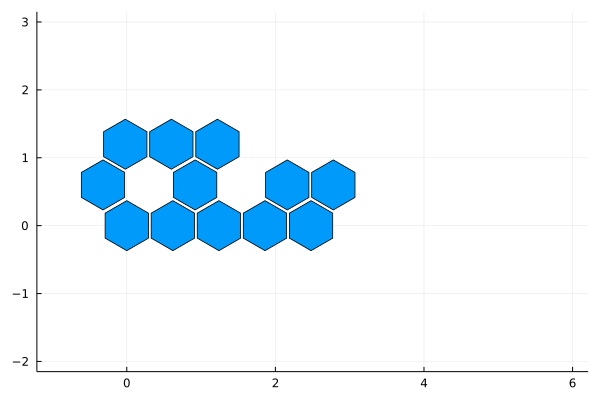

In [77]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

function render(PPHW::DecisionMakingProblems.PredatorPreyHexWorldMG)
    diff_x = 0.62
    diff_y = 0.6
    diff_odd = 0.3

    S = PPHW.hexes

    X = [(s[1] * diff_x + diff_odd * s[2]) for s in S]
    Y = [(s[2] * diff_y) for s in S]

    scatter(X, Y, 
        markershape = :hexagon, 
        markersize = 25, 
        legend = nothing)
    plot!(rectangle(7, 5, -1, -2), opacity = 0.0)
end

render(pphw)

In [82]:
function render(pphw::DecisionMakingProblems.PredatorPreyHexWorldMG, π; tit = "", current_state = nothing)
    # constant setting plot
    mg = MG(pphw)
    diff_x = 0.62
    diff_y = 0.6
    diff_odd = 0.3
    direct = Dict([(1, (1, 0)), (2, (1, 1)),
                (3, (-1, 1)), (4, (-1, 0)),
                (5, (-1, -1)), (6, (1, -1))])

    S = mg.𝒮    
    X = [(s[1] * diff_x + diff_odd * s[2]) for s in pphw.hexes]
    Y = [(s[2] * diff_y) for s in pphw.hexes]
    function my_color(s)
        if current_state == nothing
            return :silver
        end
        if s == pphw.hexes[current_state[1]]
            return :tomato2
        elseif s == pphw.hexes[current_state[2]]
            return :royalblue
        else  
            return :silver
        end
    end
    colors = [my_color(s) for s in pphw.hexes]
    # setup grad color
    # IJulia.clear_output(true)
    fig = scatter(X, Y, 
        markershape = :hexagon, 
        markercolor = colors,
        makerstrokewidth = 5,
        markersize = 25,
        legend = nothing,
        axis = nothing,
        title = tit
        )
    if (current_state != nothing && current_state[1] != current_state[2])
        for (i, s) in enumerate(current_state)
            x = pphw.hexes[s][1] * diff_x + diff_odd * pphw.hexes[s][2]
            y = pphw.hexes[s][2] * diff_y
            a = rand(SetCategorical(mg.𝒜[i], [π[i](current_state, ai) for ai in mg.𝒜[i]]))
            dx, dy = direct[a]
            dx /= 100; dy /= 100
            x += dx * 15
            y += dy * 15
            plot!([x, x + dx],
                [y, y + dy],
                arrow = true,
                linewidth = 2,
                color = :black
            )
        end
    end
    plot!(rectangle(7, 5, -1, -2), opacity = 0.0)
    return fig
end

render (generic function with 2 methods)

In [92]:
Base.:+(a::Tuple{Float64, Float64}, b::Tuple{Float64, Float64}) = (a[1] + b[1], a[2] + b[2])
Base.:+(a::Float64, b::Tuple{Float64, Float64}) = (a * b[1], a *  b[2])

function next_step(𝒫::MG, π, s)
    a = Tuple(rand(SetCategorical(𝒫.𝒜[i], [π[i](s, ai) for ai in 𝒫.𝒜[i]])) for i in 𝒫.ℐ)
    s′ = rand(SetCategorical(𝒫.𝒮, [𝒫.T(s, a, s′) for s′ in 𝒫.𝒮]))
    r = 𝒫.R(s′, a)
    return s′, r
end

function visualized_simulate(pphw::DecisionMakingProblems.PredatorPreyHexWorldMG, π)
    𝒫 = MG(pphw)
    # s = rand(𝒫.𝒮)
    s = (3, 10)
    states, rewards = [s], [(0.0, 0.0)]
    tot_reward = (0.0, 0.0)
    anim = Animation()
    step = 0
    while true
        frame(anim,
            render(pphw, π, tit = string("Step: ", step, "\nReward: ", tot_reward), current_state = s)
        )
        if rewards[length(rewards)][1] > 0
            gif(anim, "simulation.gif", fps = 1)
            return states, rewards
        end
        s′, r = next_step(𝒫, π, s)
        s = s′
        push!(states, s)
        push!(rewards, Tuple(r))
        step += 1
        tot_reward = tot_reward + ((𝒫.γ ^ step) * r[1], (𝒫.γ ^ step) * r[2]) 
    end
end

π = load("trained_pi.jld", "trained_pi")
pphw = PredatorPreyHexWorld()
visualized_simulate(pphw, π)

┌ Info: Saved animation to 
│   fn = f:\OneDrive - VNU-HCMUS\Tus\University\Junior\AI\AI-Decision-Making\PredatorPreyHexWorld\simulation.gif
└ @ Plots C:\Users\tubmt\.julia\packages\Plots\UeTBV\src\animation.jl:114


([(3, 10), (5, 11), (10, 12), (11, 12), (12, 7), (12, 7), (7, 7)], [(0.0, 0.0), (-1.0, -1.0), (-1.0, -1.0), (-1.0, -1.0), (-1.0, -1.0), (-1.0, -1.0), (10.0, -100.0)])